In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential, Model

from keras.layers import Activation, Flatten, Dense,BatchNormalization, Dropout
from keras.applications.inception_resnet_v2  import InceptionResNetV2
from tensorflow.keras.optimizers import Adam
from matplotlib.pyplot import imshow
from keras.models import load_model
from keras.applications  import InceptionV3
from tensorflow.keras.utils import load_img, img_to_array 
from sklearn.model_selection import train_test_split
import cv2
import shutil
import glob
import os
from PIL import Image

In [24]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
No_tumor = '/content/drive/MyDrive/classification/classification/picture/no'
Have_tumor = '/content/drive/MyDrive/classification/classification/picture/yes'
Main_location = '/content/drive/MyDrive/classification/classification/picture'

In [26]:
list_brain_image=[No_tumor, Have_tumor]
classes=['No_tumor', 'Have_tumor']
images_location=[]
labels=[]


for i,j in zip(list_brain_image, classes):
    list_of_file=os.listdir(i)
    for f in list_of_file:
        image_location=os.path.join (i,f)
        images_location.append(image_location)
        labels.append(j)

 

print ('Number of image: ', len(images_location), '   Number of image has label: ', len(labels))


Number of image:  253    Number of image has label:  253


In [27]:
Location=pd.Series(images_location, name='location')
Label=pd.Series(labels, name='labels')

#connect the path of brain image and their label (Have_tumor , No_tumor)
connect_image_label=pd.concat([Location,Label], axis=1)

#draw the table to visualize 
connect_image_label=pd.DataFrame(np.array(connect_image_label).reshape(253,2), columns = ['location', 'labels'])
connect_image_label.head()


,location,labels
0,/content/drive/MyDrive/classification/classifi...,No_tumor
1,/content/drive/MyDrive/classification/classifi...,No_tumor
2,/content/drive/MyDrive/classification/classifi...,No_tumor
3,/content/drive/MyDrive/classification/classifi...,No_tumor
4,/content/drive/MyDrive/classification/classifi...,No_tumor


In [28]:
print(connect_image_label['labels'].value_counts())

Have_tumor    155
No_tumor       98
Name: labels, dtype: int64


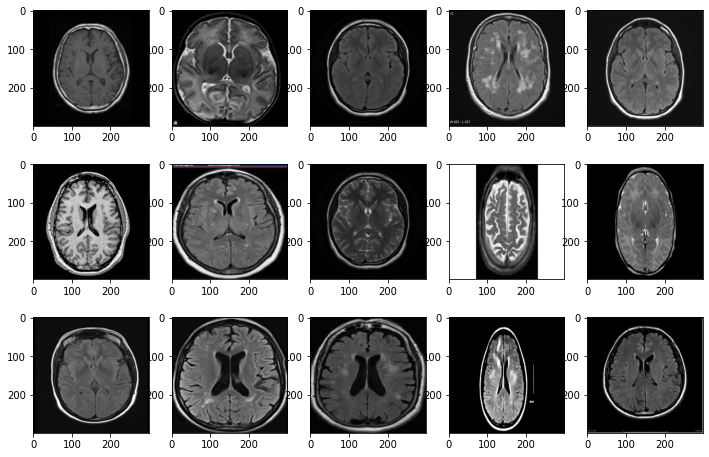

In [29]:
data =[]

for path in images_location:
  img = Image.open(path)
  img = img.resize((299,299))
  img = np.array(img)
  data.append(img)

plt.figure(figsize=(12,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(data[i], cmap="gray")

    
plt.show()

In [30]:
#split the data to 3 part : train dataset, test dataset, validation data
train, test = train_test_split(connect_image_label, train_size=0.80, random_state=3)
train, valid = train_test_split(train, train_size=0.95, random_state=3)

print(f"train set: {train.shape}")
print(f"test set: {test.shape}")
print(f"validation set: {valid.shape}")

train set: (191, 2)
test set: (51, 2)
validation set: (11, 2)


In [31]:
#rescale image from rgb (0-255) to (0,1)
train_image_datagen = ImageDataGenerator(rescale = 1./255.)
test_image_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [35]:
train_datagen = train_image_datagen.flow_from_dataframe(dataframe = train,
                                              x_col = 'location', y_col ='labels',
                                              target_size = (299,299), batch_size = 20, 
                                              class_mode = 'binary', shuffle = True)

validation_datagen = train_image_datagen.flow_from_dataframe(valid, 
                                            target_size=(299,299), x_col = 'location', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 20, shuffle=True)

test_datagen = test_image_datagen.flow_from_dataframe(test,
                                            target_size = (299,299), x_col = 'location', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 15, shuffle = False)

Found 191 validated image filenames belonging to 2 classes.
Found 11 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [33]:
train_datagen.class_indices

{'Have_tumor': 0, 'No_tumor': 1}

In [36]:
base_model =  InceptionResNetV2( weights='imagenet', include_top=False, input_shape=(299,299,3)
)
     
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_612 (Ba  (None, 8, 8, 1536)       6144      
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 8, 8, 128)         196736    
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(train_datagen, validation_data = validation_datagen, epochs = 20)

Epoch 1/20
10/10 [==============================] - 31s 1s/step - loss: 1.2765 - accuracy: 0.6545 - val_loss: 1.6103 - val_accuracy: 0.5455
Epoch 2/20
10/10 [==============================] - 7s 668ms/step - loss: 0.5885 - accuracy: 0.8482 - val_loss: 16.5667 - val_accuracy: 0.4545
Epoch 3/20
10/10 [==============================] - 7s 674ms/step - loss: 0.2683 - accuracy: 0.9267 - val_loss: 2294.1423 - val_accuracy: 0.4545
Epoch 4/20
10/10 [==============================] - 7s 679ms/step - loss: 0.0381 - accuracy: 0.9948 - val_loss: 1336.7894 - val_accuracy: 0.4545
Epoch 5/20
10/10 [==============================] - 7s 686ms/step - loss: 0.0463 - accuracy: 0.9948 - val_loss: 178.7083 - val_accuracy: 0.4545
Epoch 6/20
10/10 [==============================] - 7s 689ms/step - loss: 0.0200 - accuracy: 0.9948 - val_loss: 114.6467 - val_accuracy: 0.4545
Epoch 7/20
10/10 [==============================] - 7s 695ms/step - loss: 0.1260 - accuracy: 0.9634 - val_loss: 98.3989 - val_accuracy: 0.3

In [38]:

model.evaluate(test_datagen)

4/4 [==============================] - 1s 136ms/step - loss: 0.4179 - accuracy: 0.8235


[0.41790446639060974, 0.8235294222831726]

In [39]:
model.save('inceptionresnetv2_4.h5') 
del model  


model = load_model('inceptionresnetv2_4.h5')

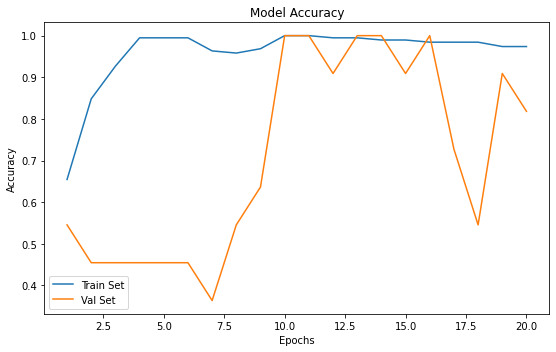

In [40]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Train Set')
plt.plot(epochs_range, validation_accuracy, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')



plt.tight_layout()
plt.show()

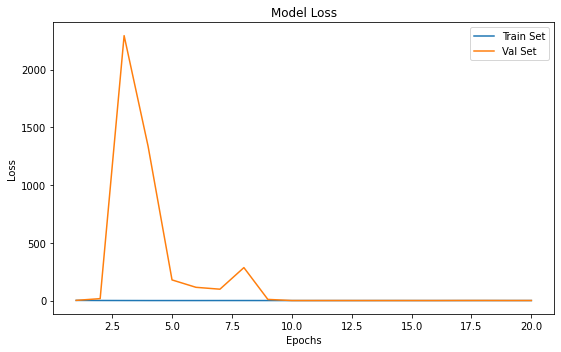

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, validation_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [19]:
def tumor_result(number):
    if number < 0.5:
        return 'Its a Tumor'
    else:
        return 'No, Its not a tumor'

(1, 299, 299, 3)
1/1 [==============================] - 4s 4s/step


'No, Its not a tumor'

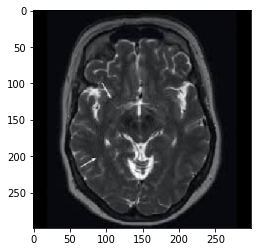

In [43]:
img_path = '/content/drive/MyDrive/classification/classification/picture/no/3 no.jpg'
img = image.load_img(img_path, target_size=(299,299,3))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_batch = np.array(img_batch).astype('float32')/255
print(img_batch.shape)
plt.imshow(img)
res = model.predict(img_batch)
res
tumor_result(res)

(1, 299, 299, 3)
1/1 [==============================] - 0s 71ms/step


'Its a Tumor'

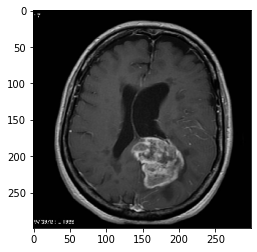

In [44]:
img_path = '/content/drive/MyDrive/classification/classification/picture/yes/Y96.jpg'
img = image.load_img(img_path, target_size=(299,299,3))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_batch = np.array(img_batch).astype('float32')/255
print(img_batch.shape)
plt.imshow(img)
res = model.predict(img_batch)
tumor_result(res)
